# Introduction 

In this notebook I illustrate how motion affects functional magnetic resonance images (fMRI) acquired without a task. I introduce the most wide-spread technique to estimate and  correct these artefacts, namely mass univariate regression of motion parameters. I also extend this approach using a data dimension reduction based on a spatial InfoMax independent component analysis. 

I used the data from three subjects, with low, mild and high motion respectively (for the record, the IDs were HC0040123, SZ0040142 and SZ0040084). The data was raw, and I used the preprocessing pipeline only to extract estimated motion parameters and a basis of slow time drifts adapted to the sampling frequency of the fMRI time series. Only results for the low motion subject are presented here, I will comment on the differences in the conclusion section below.

I will just start by loading the niak library and setting the path for the experiment. By the way, this notebook will run inside a jupyter notebook with [Octave]() installed as well the Octave kenerl for Jupyter. At the moment the data is not public, but I will release it soon and add automatic data Fetchers. At this point it should be pretty straightforward to reproduce these experiments using a NIAK docker image. 

In [1]:
subject_id = 'HC0040123';
path_work = '/home/pbellec/data/deepmotion/xp_2016_07_27_final';
cd
build_path niak psom
cd(path_work)

Adding library niak to the search path.

Adding library psom to the search path.



# Mass univariate regression of motion parameters

### fMRI time series

Let's start by loading the data from subject SZ0040084 from the COBRE preprocessed sample, who has large motion (about 1 mm FD across all frames). 

In [2]:
[hdr,vol] = niak_read_vol(['rest_' subject_id '.nii.gz']);
size(vol)

ans =

    64    64    33   150



As we can see this is a 3D+t dataset, with 64x64x33 voxels and 150 time frames.

### Motion parameters and drifts

Now let's load confound variables:

In [3]:
tab = niak_read_csv_cell(['fmri_' subject_id '_session1_run1_n_confounds.tsv.gz']);
size(tab)
tab(1,:)

ans =

   151    22

ans = 
{
  [1,1] = motion_tx
  [1,2] = motion_ty
  [1,3] = motion_tz
  [1,4] = motion_rx
  [1,5] = motion_ry
  [1,6] = motion_rz
  [1,7] = FD
  [1,8] = scrub
  [1,9] = slow_drift
  [1,10] = slow_drift
  [1,11] = slow_drift
  [1,12] = slow_drift
  [1,13] = slow_drift
  [1,14] = slow_drift
  [1,15] = wm_avg
  [1,16] = vent_avg
  [1,17] = global_signal_pca
  [1,18] = compcor
  [1,19] = compcor
  [1,20] = compcor
  [1,21] = compcor
  [1,22] = compcor
}


We have 151 rows (one per time frame, plus a first row of labels), and 22 columns corresponding to different "confound" variables, which labels are listed right above. Let's build a matrix with the motion variables and slow time drifts:

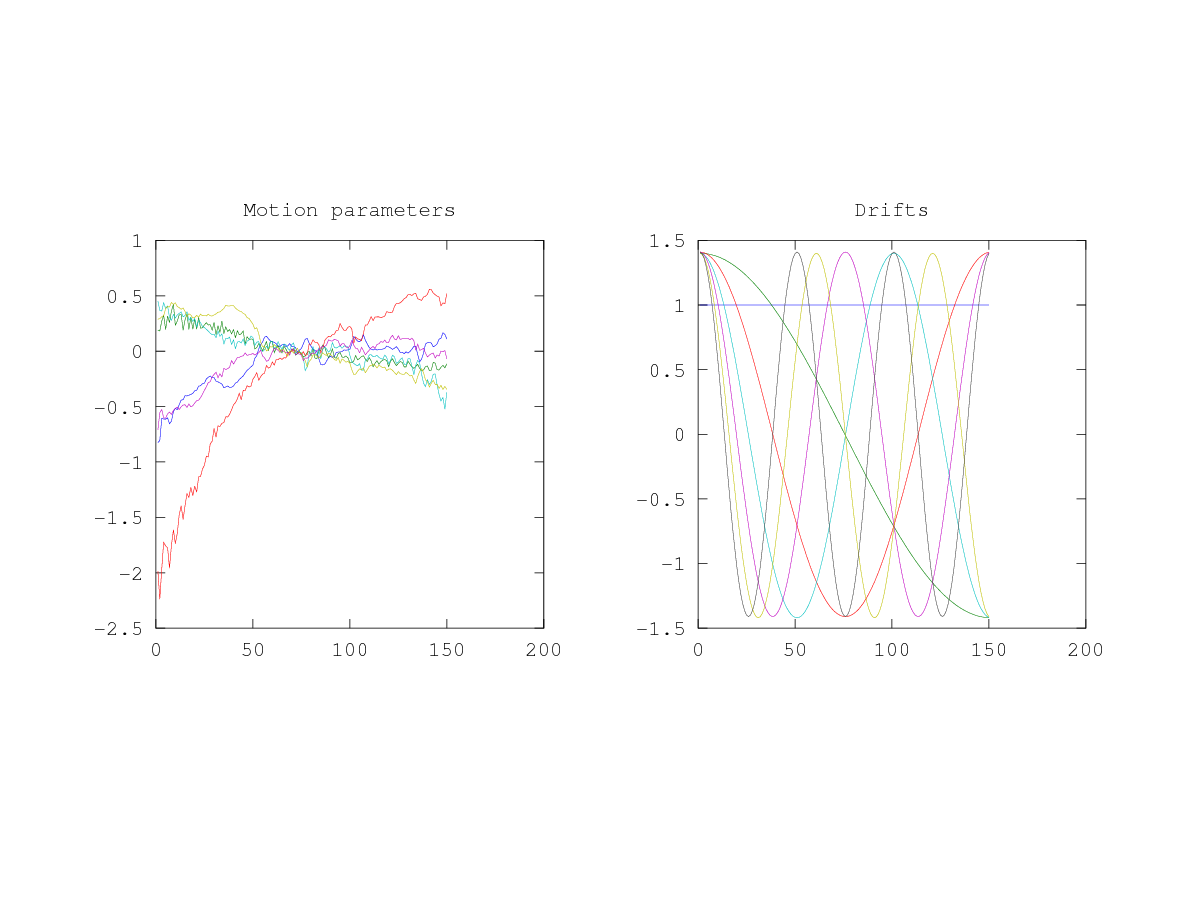

In [4]:
Xmotion = str2double(tab(2:end,1:6));
Xdrifts = [ones(size(vol,4),1) str2double(tab(2:end,9:14))];
subplot(1,2,1), plot(Xmotion), title('Motion parameters'), axis square
subplot(1,2,2), plot(Xdrifts), title('Drifts'), axis square

The motion parameters contain a lot of slow time drifts, here modeled with a basis of discrete cosines covering up to 0.01 Hz. The slow time drifts typically explain a massive amount of variance in the data. This is interesting, but we would like to assess the impact of motion besides smooth drifts. We will try to separate the effect of motion parameters and drifts through regression. 

So now let's extract a mask of the brain, and reorganize the fMRI data into a time x space array, and also regress the drifts:

### time x space array and regression of drifts 

ans =

     150   21736



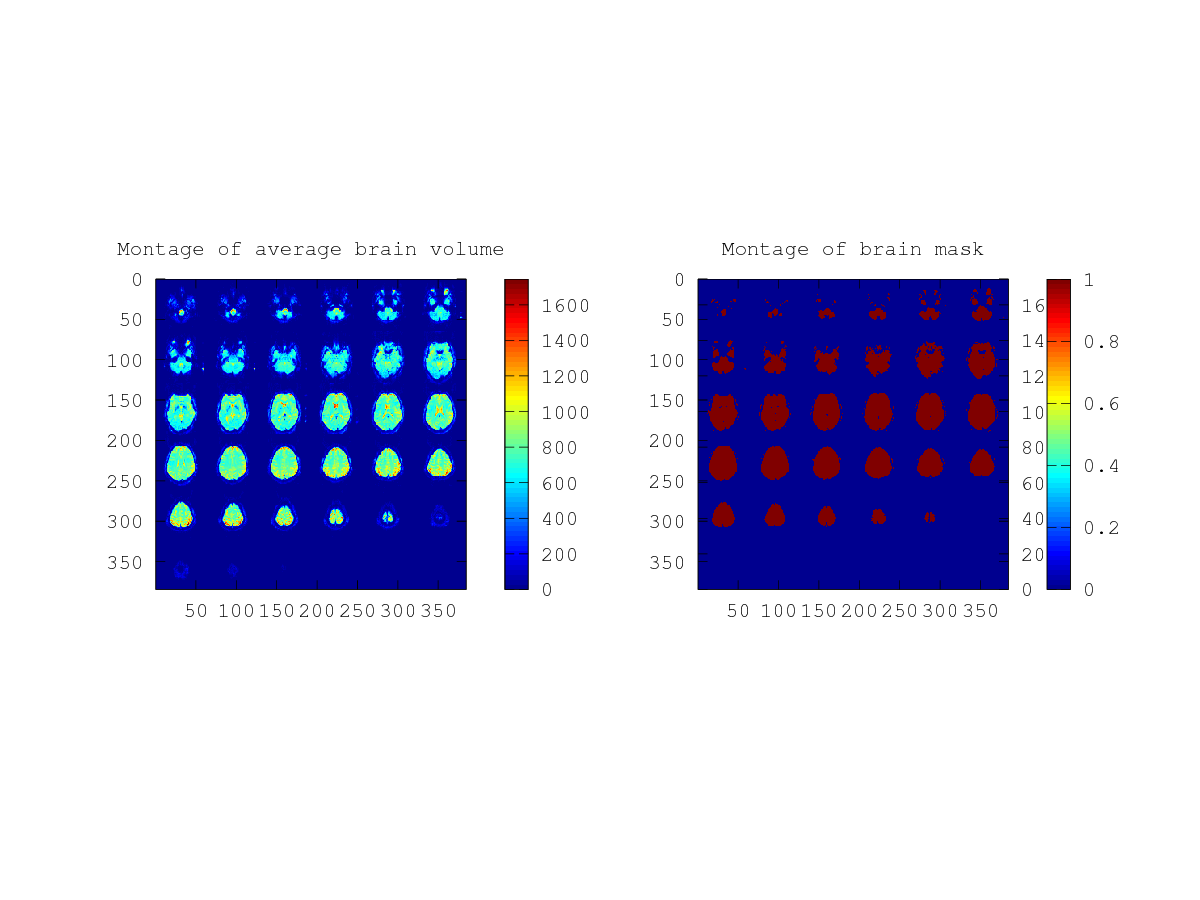

In [5]:
mask = niak_mask_brain(vol);
tseries = niak_vol2tseries(vol,mask);
[beta_drifts,tseries] = niak_lse(tseries,Xdrifts);
[beta_dmotion,Xmotion] = niak_lse(Xmotion,Xdrifts);
subplot(1,2,1)
niak_montage(mean(vol,4));
title('Montage of average brain volume')
subplot(1,2,2)
niak_montage(mask)
title('Montage of brain mask')
size(tseries)

So we have about 20k voxels inside the brain mask. The time series array is 150 x 20k (time x space, with voxels ordered arbitrarily). We can now regress the motion parameters onto the fMRI time series:

In [6]:
beta = niak_lse(tseries,Xmotion);
size(beta)

ans =

       6   21736



Each row of `beta` is a map of regression coefficients attached to the six motion parameters, one coefficient per voxel. The regression is implemented independently at each voxel, and the target is the time series of a voxel. Let's just compute the fraction of explained sum of squares and pick a voxel with the largest value to illustrate that: 

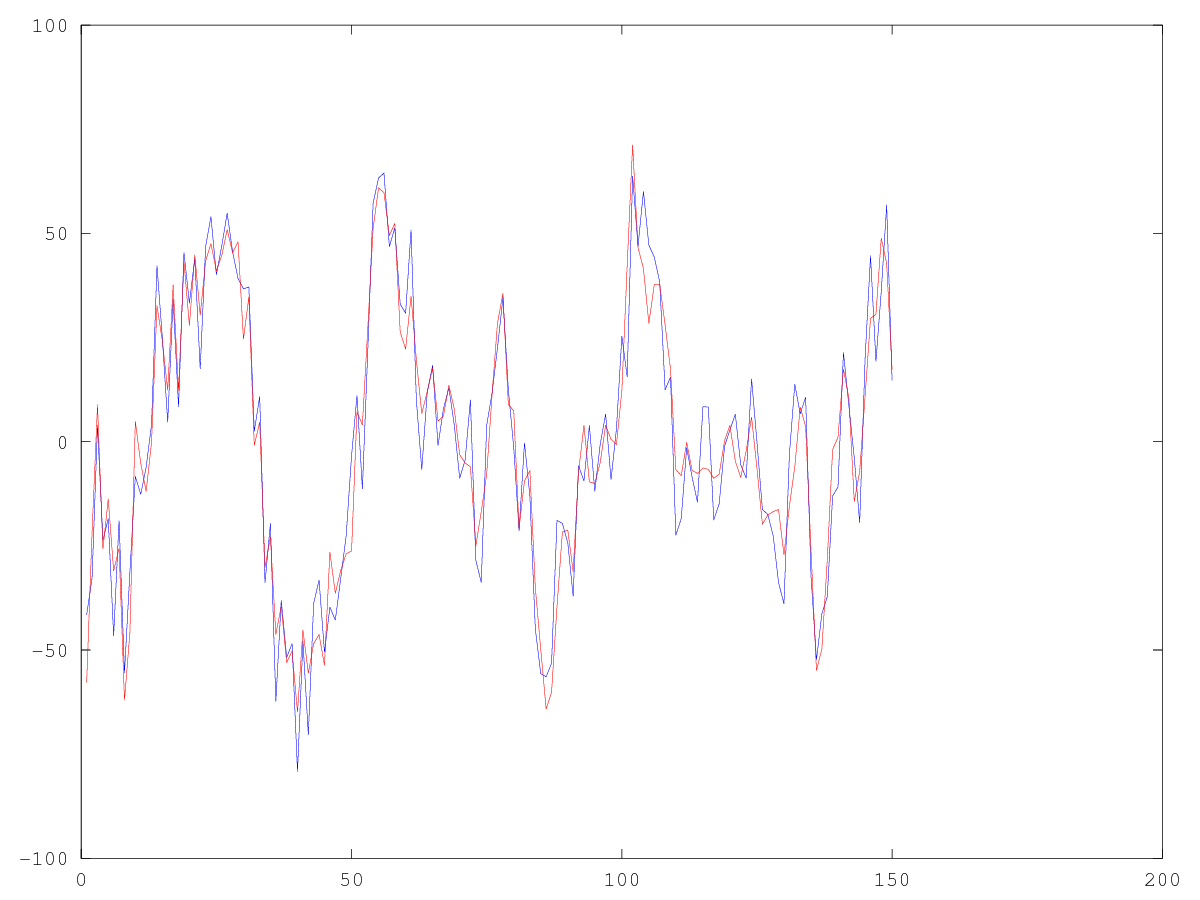

In [7]:
tseries_pred = Xmotion*beta; % Predicted time series
R2 = 1 - sum((tseries-tseries_pred).^2,1)./sum(tseries.^2,1);
[val,ind] = max(R2);
plot(tseries(:,ind))
hold on
plot(tseries_pred(:,ind),'r')

Not that small fluctuations are somewhat accurately predicted, not just the trend. Let's dig a bit more into this, by showing the percentage of explained variance as a brain map. I have selected a couple slices to be able to see better. 

ans =  0.27128


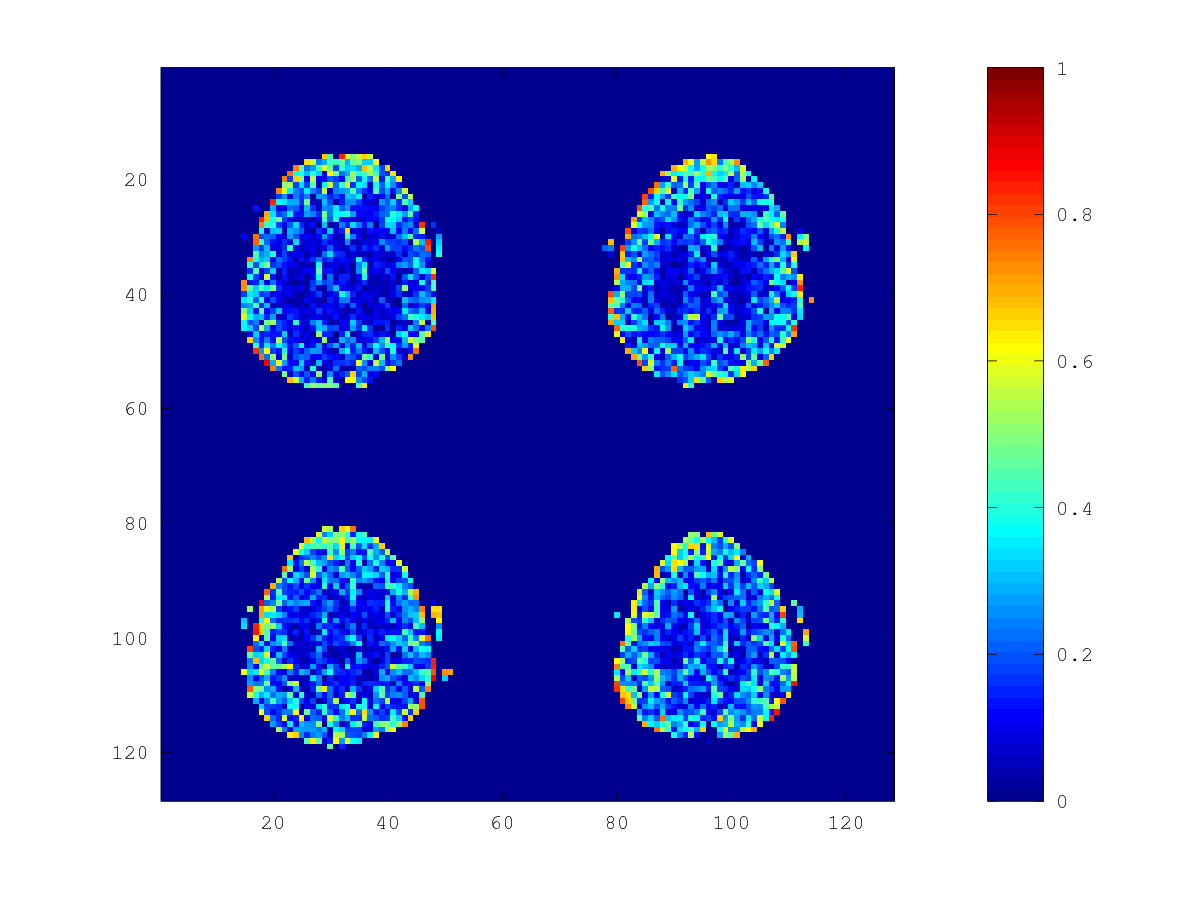

In [8]:
R2_map = niak_tseries2vol(R2,mask);
opt_v.vol_limits = [0 1];
niak_montage(R2_map(:,:,20:23),opt_v)
mean(R2)

So, this simple model explains large fractions of the data around the brain (sometimes close to 100%!). An average inside the brain we explain 27% sum-of-squares. However this has to be taken with a grain of salt: the regression model was fitted to the whole dataset, and we may be overfitting the time series.  

### Model cross-validation

Let's now cross-validate the mass univariate regression of motion parameters, using ten folds, and extract a proper generalization error. Ideally we would exclude time points too close to the training set from the test set, because there is temporal autocorrelation, but I won't do that for simplicity.

In [9]:
folds = floor(linspace(1,size(tseries,1),11))
tseries_pred = zeros(size(tseries));
tseries_test = zeros(size(tseries_pred));
for ff = 1:10
    ff
    
    %% Prepare the training data - we will need to keep 
    %% track of the regression parameters for the drifts
    %% to re-apply them on the test data
    %% Those are the beta_dtseries and beta_dmotion parameters
    mask_training = true(size(tseries,1),1);
    mask_training(folds(ff):folds(ff+1)) = false;
    tseries_training = niak_vol2tseries(vol(:,:,:,mask_training),mask);
    Xdrifts = [ones(size(vol,4),1) str2double(tab(2:end,9:14))];
    Xdtraining = Xdrifts(mask_training,:);
    [beta_dtseries,tseries_training] = niak_lse(tseries_training,Xdtraining);
    Xmotion = str2double(tab(2:end,1:6));
    X_training = Xmotion(mask_training,:);
    [beta_dmotion,X_training] = niak_lse(X_training,Xdtraining);
    
    %% Learn the regression parameters to predict time series 
    beta = niak_lse(tseries_training,X_training);
    
    %% Test on independent data
    %% We re-use prediction parameters beta_dmotion and beta_dtseries (for correction of slow drifts)
    %% as well as the beta which predict the time series from motion parameters
    X_test = Xmotion(~mask_training,:) - Xdrifts(~mask_training,:)*beta_dmotion; 
    tseries_pred(~mask_training,:) = X_test*beta; % Predicted time series on test time points
    tseries_test(~mask_training,:) = niak_vol2tseries(vol(:,:,:,~mask_training),mask)-Xdrifts(~mask_training,:)*beta_dtseries; % Time series on test time points
end

folds =

     1    15    30    45    60    75    90   105   120   135   150

ff =  1
ff =  2
ff =  3
ff =  4
ff =  5
ff =  6
ff =  7
ff =  8
ff =  9
ff =  10


Let's compute the fraction of explained sum of squares, between the predicted and test data (note that the way drifts were corrected will vary slightly across folds). Let's also pick a voxel that was very well modeled and compare the predicted and test time series. 

val =  0.97626
ind =  7457


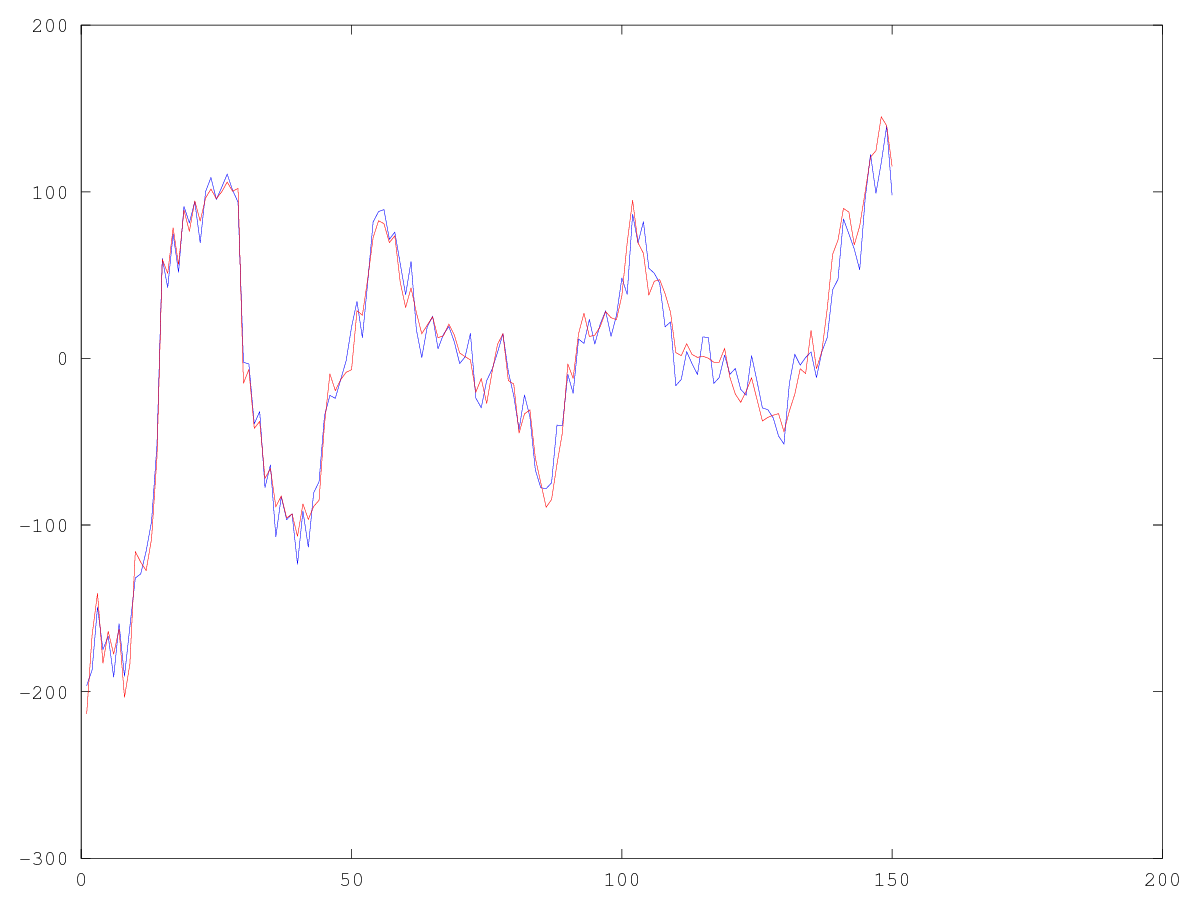

In [10]:
R2 = 1 - sum((tseries_test-tseries_pred).^2,1)./sum(tseries_test.^2,1);
[val,ind] = max(R2)
plot(tseries_test(:,ind))
hold on
plot(tseries_pred(:,ind),'r')

A whopping 97% of variance explained! Not bad... but this is 1 out of 20k voxels we picked, and this may have happened randomly. Let's check how this actually generalizes across the brain. 

ans =  0.082570


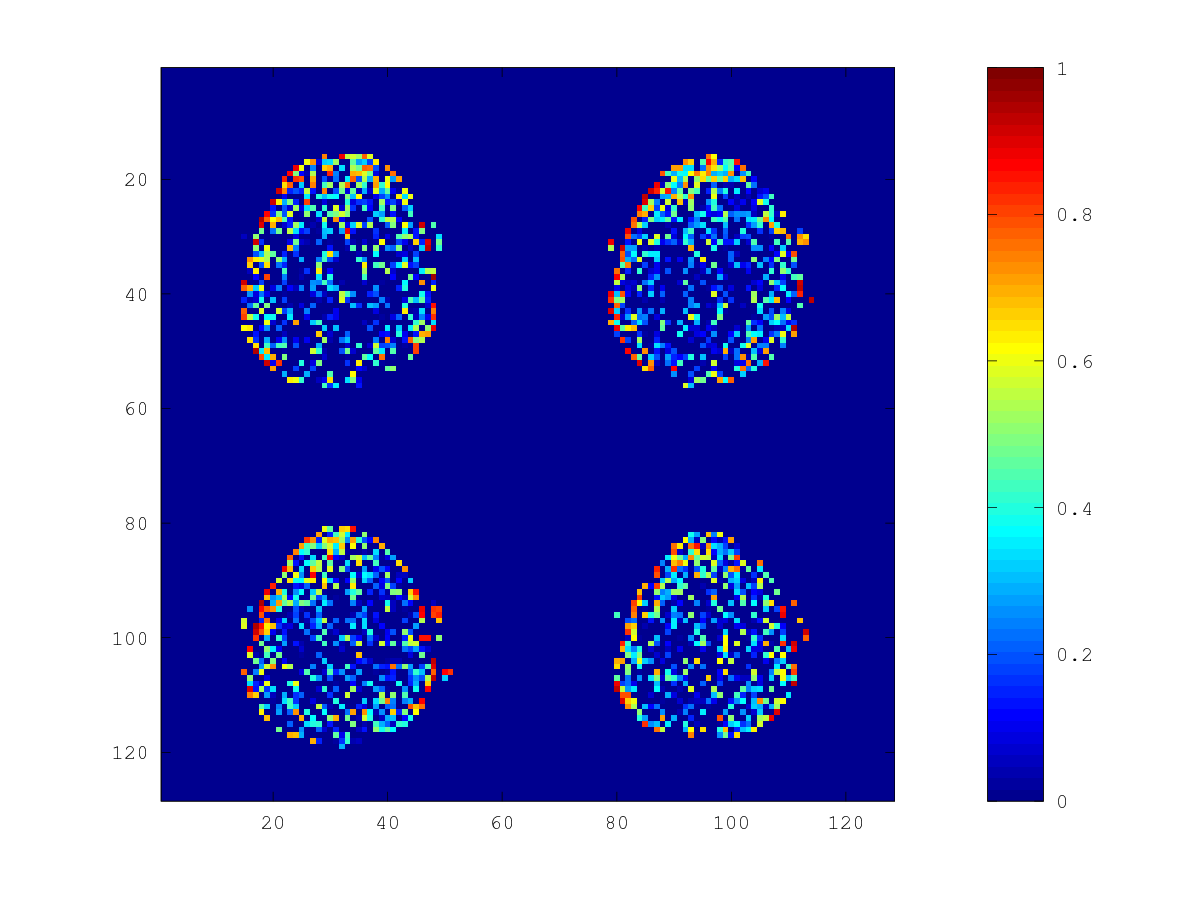

In [11]:
R2_map = niak_tseries2vol(R2,mask);
opt_v.vol_limits = [0 1];
opt_v.fwhm = 0;
niak_montage(R2_map(:,:,20:23),opt_v)
hdr.file_name = 'test.nii.gz';
niak_write_vol(hdr,R2_map)
mean(R2)

At the edges of the brain, the prediction accuracy is generally very high, above 90% explained sum-of-squares in many cases. Inside the brain accuracy is much more modest, and we clearly had over-fitting in our previous experiment. Overall, this model explains about 8% of global variance. Not bad, but properly far from optimal, although this is a subject with a low level of motion. 

# Independent component analysis

### Data preparation

Let's now try a prediction using ICA for data dimension reduction. In order to make the two main sections of this notebook independent, I will first reload and re-prepare all the necessary data:

In [12]:
[hdr,vol] = niak_read_vol(['rest_' subject_id '.nii.gz']);
tab = niak_read_csv_cell(['fmri_' subject_id '_session1_run1_n_confounds.tsv.gz']);
mask = niak_mask_brain(vol);
Xmotion = str2double(tab(2:end,1:6));
Xdrifts = [ones(size(vol,4),1) str2double(tab(2:end,9:14))];
tseries = niak_vol2tseries(vol,mask);
[beta_drifts,tseries] = niak_lse(tseries,Xdrifts);
[beta_dmotion,Xmotion] = niak_lse(Xmotion,Xdrifts);

### Spatial ICA

Now let's run a spatial ICA with the InfoMax algorithm, which is the most popular in the fMRI literature. We will arbitrarily use 40 components. 

In [13]:
opt_ica.type_nb_comp = 0;
opt_ica.param_nb_comp = 40;
res = niak_sica(tseries,opt_ica);


Input data size [40,21736] = 40 channels, 21736 frames.
After PCA dimension reduction,
  finding 40 ICA components using logistic ICA.
Initial learning rate will be 0.000129724, block size 49.
Learning rate will be multiplied by 0.9 whenever angledelta >= 60 deg.
Training will end when wchange < 1e-05 or after 300 steps.
Online bias adjustment will be used.
Removing mean of each channel ...
Final training data range: -709.264 to 930.626
    Reducing the data to 40 principal dimensions...
Using the sphering matrix as the starting weight matrix ...
Returning the identity matrix in variable "sphere" ...
Beginning ICA training ...
step 1 - lrate 0.000130, wchange 0.105423
step 2 - lrate 0.000130, wchange 0.038592
step 3 - lrate 0.000130, wchange 0.028957, angledelta 83.6 deg
step 4 - lrate 0.000117, wchange 0.024811, angledelta 74.6 deg
step 5 - lrate 0.000105, wchange 0.019625, angledelta 78.2 deg
step 6 - lrate 0.000095, wchange 0.016978, angledelta 90.2 deg
step 7 - lrate 0.000085, wch

Let's examine the results. This is a very old implementation, with French field names... The `poids` contains temporal sources, and `composantes` the associated spatial maps. I reorganized them to have two arrays, one called `Xica` for the temporal sources (size time x (number of components)) and another, called `Wica` for the spatial sources (size (number of components) x (number of voxels)).

In [14]:
Xica = res.poids; 
Wica = res.composantes';
size(Xica)
size(Wica)

ans =

   150    40

ans =

      40   21736



Let's check if motion parameters can explain a lot of variance in specific ICA components:

In [15]:
beta_motion_to_ica = niak_lse(Xica,Xmotion);
Xica_pred = Xmotion*beta_motion_to_ica;
R2_motion2ica = 1 - sum((Xica-Xica_pred).^2,1)./sum(Xica.^2,1);

ans =

 Columns 1 through 8:

   0.96620   0.84486   0.68348   0.67231   0.59622   0.54334   0.52705   0.43168

 Columns 9 and 10:

   0.41878   0.39447



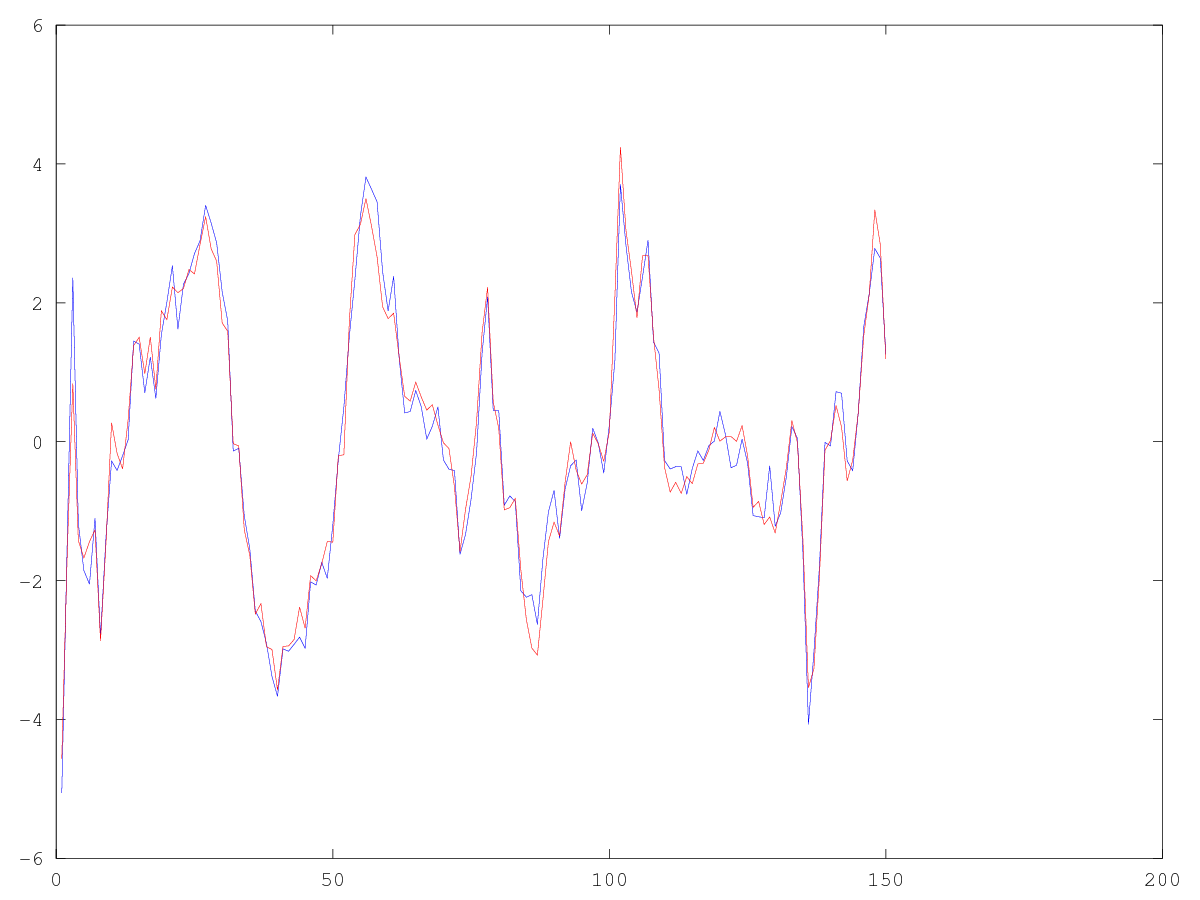

In [16]:
[val_ica,order_ica] = sort(R2_motion2ica,'descend');
val_ica(1:10)
ind_ica = order_ica(1);
plot(Xica(:,ind_ica))
hold on
plot(Xica_pred(:,ind_ica),'r')

This is getting interesting. For one ICA component, over 95% of the variance can be explained by motion parameters. Many other show strong association, with over 50% of explained variance. Let's check the spatial map of the component most strongly associated with motion: 

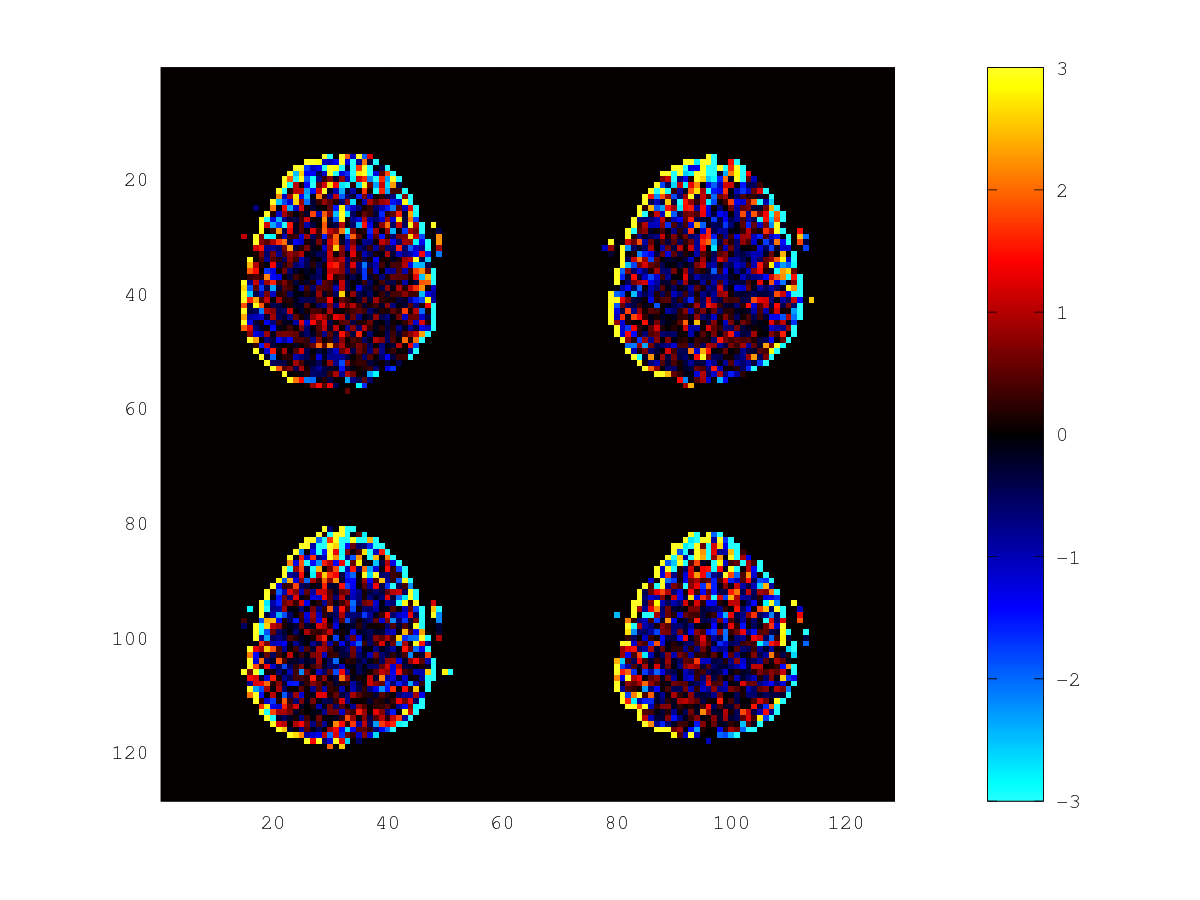

In [17]:
opt_v = struct;
opt_v.vol_limits = [-3 3];
opt_v.type_color = 'hot_cold';
Wica_map = niak_tseries2vol((Wica(ind_ica,:)),mask);
niak_montage(Wica_map(:,:,20:23),opt_v)

This is non-ambiguous: clean motion artifacts around the brain. One positive arc in the direction of motion, and a negative arc in the opposite direction. Inside the brain though the coefficients look quite messy. This type of independent component was already described in the first ever ICA fMRI paper, by McKeown et al. (HBM, 1998). They are systematically observed in any fMRI dataset. 

### Predicting time series from ICA motion components

So I tried a simple predictor based on the ICA decomposition. First, I predict the ICA time courses from the motion parameters, using a linear regression. Then I select the top 10 components most associated with motion. Finally, I reconstruct the signal using the estimated time courses (generated from motion parameters), and the ICA spatial maps for these components. On test data, I would just need to re-use the regression weights (from motion parameters to ICA time courses) and the ICA maps to make a prediction on time series. Let's check how it looks in terms of explained variance without cross-validation. I picked the voxels with the best prediction to illustrate how it worked:

val =  0.90680
ind =  8652


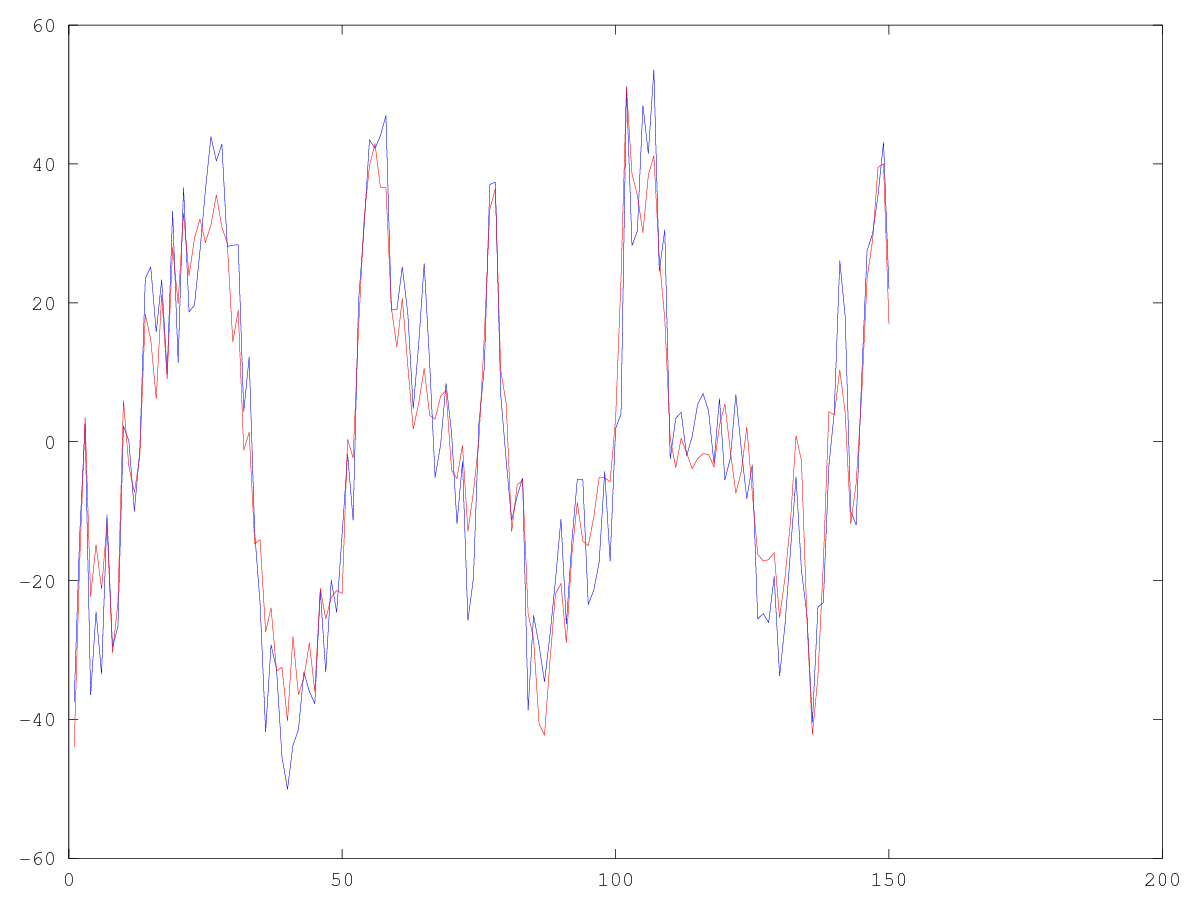

In [18]:
tseries_pred_ica = Xica_pred(:,order_ica(1:10))*Wica(order_ica(1:10),:);
R2_pred = 1 - sum((tseries-tseries_pred_ica).^2,1)./sum(tseries.^2,1);
[val,ind] = max(R2_pred)
plot(tseries(:,ind))
hold on
plot(tseries_pred_ica(:,ind),'r')

As we did for the simple regression model, let's now make a map of explained variance throughout the brain:

ans =  0.23714


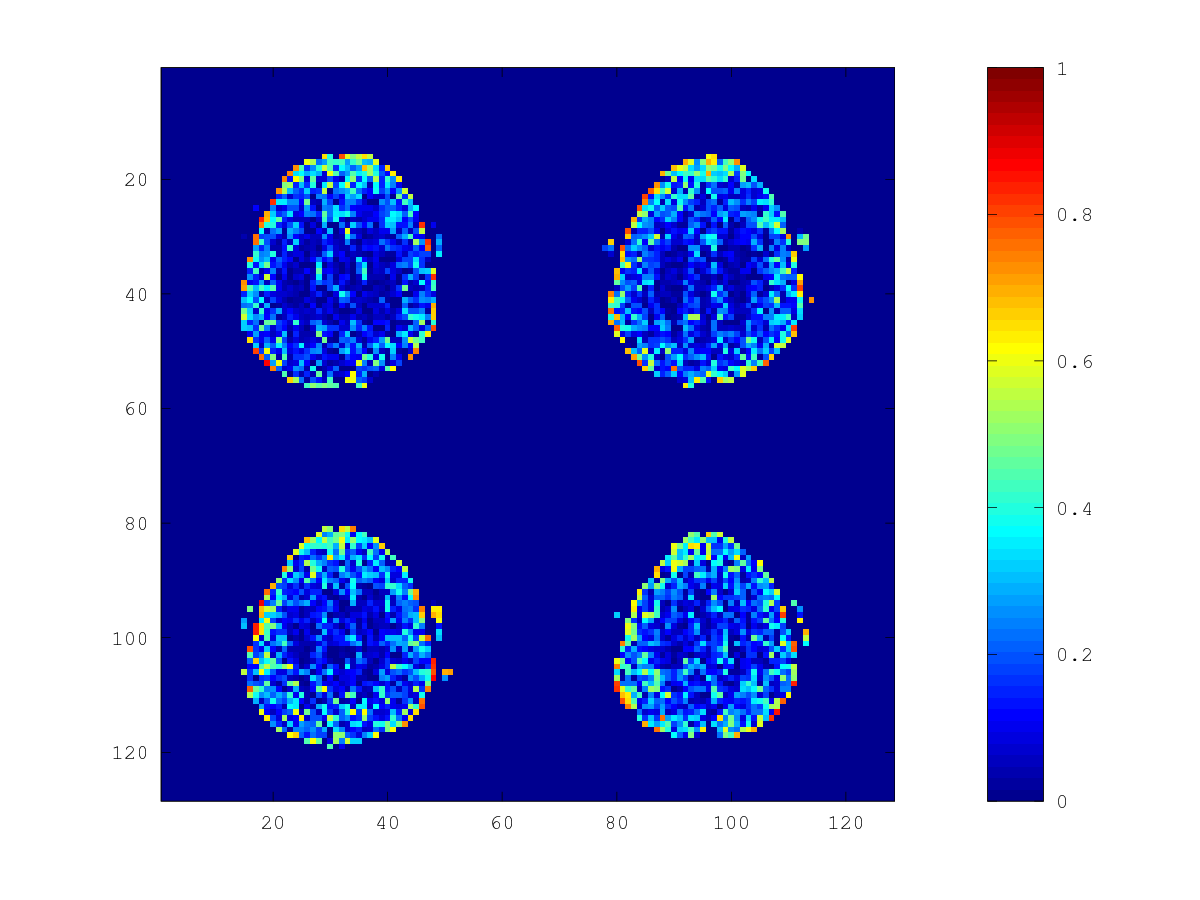

In [19]:
R2_map = niak_tseries2vol(R2_pred,mask);
opt_v = struct;
opt_v.vol_limits = [0 1];
opt_v.fwhm = 0;
niak_montage(R2_map(:,:,20:23),opt_v)
hdr.file_name = 'test.nii.gz';
niak_write_vol(hdr,R2_map)
mean(R2_pred)

So it's interesting. The overall pattern is identical to the experiment with mass univariate regression of motion parameters. The overall explained variance is slightly lower (23% as opposed to 27%), but this may just be that the ICA model has lower dimensionality, and may not overfit data as much as a consequence. 

### Cross-validation of ICA prediction

So I wrote a simple ten fold cross validation of the ICA-based prediction model:

In [20]:
folds = floor(linspace(1,size(tseries,1),11))
tseries_pred = zeros(size(tseries));
tseries_test = zeros(size(tseries_pred));
for ff = 1:10
    ff
    %% Prepare the training data - we will need to keep 
    %% track of the regression parameters for the drifts
    %% to re-apply them on the test data
    mask_training = true(size(tseries,1),1);
    mask_training(folds(ff):folds(ff+1)) = false;
    tseries_training = niak_vol2tseries(vol(:,:,:,mask_training),mask);
    Xdrifts = [ones(size(vol,4),1) str2double(tab(2:end,9:14))];
    Xdtraining = Xdrifts(mask_training,:);
    [beta_dtseries,tseries_training] = niak_lse(tseries_training,Xdtraining);
    Xmotion = str2double(tab(2:end,1:6));
    X_training = Xmotion(mask_training,:);
    [beta_dmotion,X_training] = niak_lse(X_training,Xdtraining);
    
    %% Now run the ica on the training data
    %% Also learn to predict ICA weights from motion parameters. 
    %% We will retain the top 10 components
    opt_ica.type_nb_comp = 0;
    opt_ica.param_nb_comp = 40;
    res = niak_sica(tseries_training,opt_ica);
    Xica = res.poids; 
    Wica = res.composantes';
    beta_ica = niak_lse(Xica,X_training);
    Xica_training = X_training*beta_ica;
    R2_ica = 1 - sum((Xica-Xica_training).^2,1)./sum(Xica.^2,1);
    [val_ica,order_ica] = sort(R2_ica,'descend');
    
    %% Now apply the prediction to test data
    X_test = Xmotion(~mask_training,:) - Xdrifts(~mask_training,:)*beta_dmotion; 
    Xica_pred = X_test*beta_ica;
    tseries_pred_ica(~mask_training,:) = Xica_pred(:,order_ica(1:10))*Wica(order_ica(1:10),:);
    tseries_test(~mask_training,:) = niak_vol2tseries(vol(:,:,:,~mask_training),mask)-Xdrifts(~mask_training,:)*beta_dtseries;
end

folds =

     1    15    30    45    60    75    90   105   120   135   150

ff =  1

Input data size [40,21736] = 40 channels, 21736 frames.
After PCA dimension reduction,
  finding 40 ICA components using logistic ICA.
Initial learning rate will be 0.00013251, block size 49.
Learning rate will be multiplied by 0.9 whenever angledelta >= 60 deg.
Training will end when wchange < 1e-05 or after 300 steps.
Online bias adjustment will be used.
Removing mean of each channel ...
Final training data range: -692.369 to 924.825
    Reducing the data to 40 principal dimensions...
Using the sphering matrix as the starting weight matrix ...
Returning the identity matrix in variable "sphere" ...
Beginning ICA training ...
step 1 - lrate 0.000133, wchange 0.116594
step 2 - lrate 0.000133, wchange 0.046641
step 3 - lrate 0.000133, wchange 0.038678, angledelta 81.7 deg
step 4 - lrate 0.000119, wchange 0.026189, angledelta 71.4 deg
step 5 - lrate 0.000107, wchange 0.019824, angledelta 78.1 deg
step 6 

Let's compute the proportion of variance explained at each voxel, and represent the prediction for the voxel with highest accuracy:

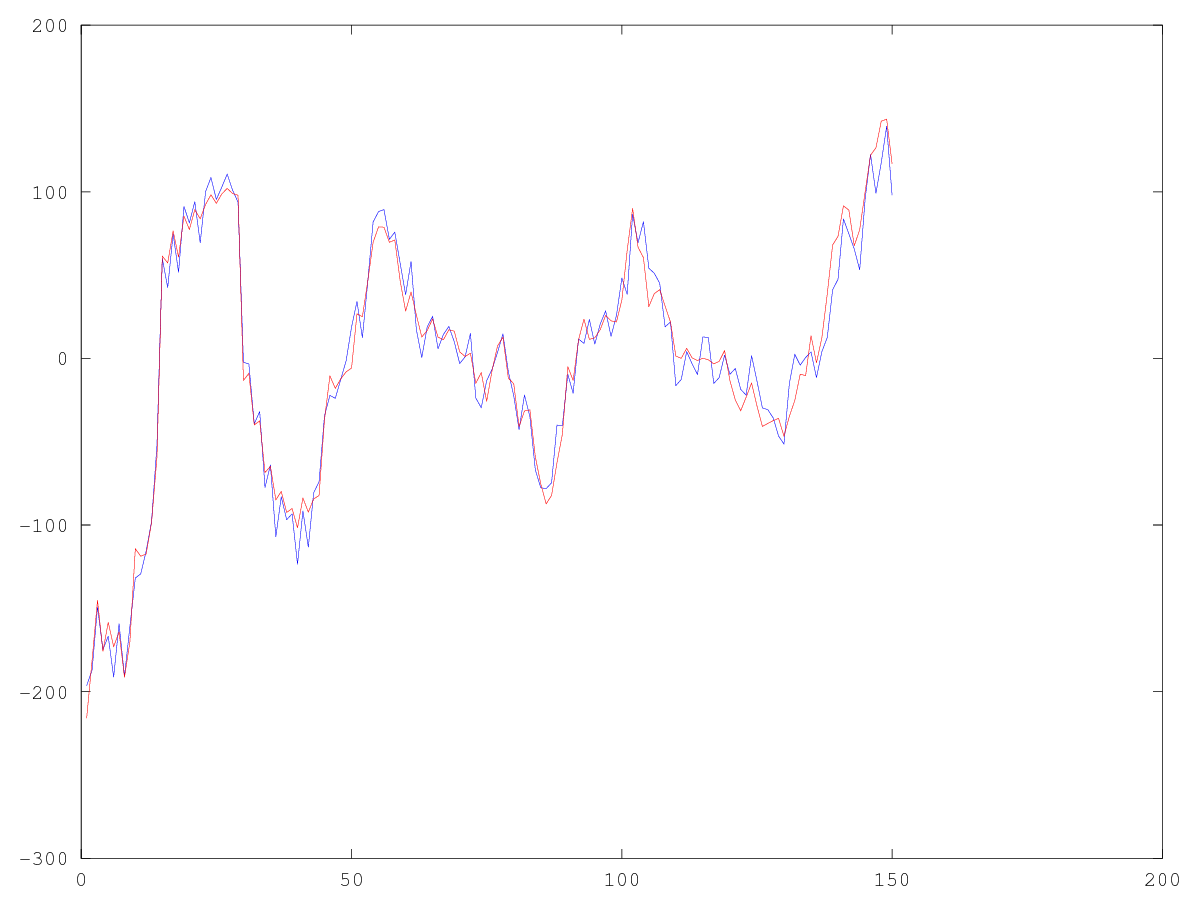

In [21]:
R2 = 1 - sum((tseries_test-tseries_pred_ica).^2,1)./sum(tseries_test.^2,1);
[val,ind] = max(R2);
plot(tseries_test(:,ind))
hold on
plot(tseries_pred_ica(:,ind),'r')

At this stage, this was expected, but it is reassuring nonetheless. Let's now examine the map of explained variance:

ans =  0.078259


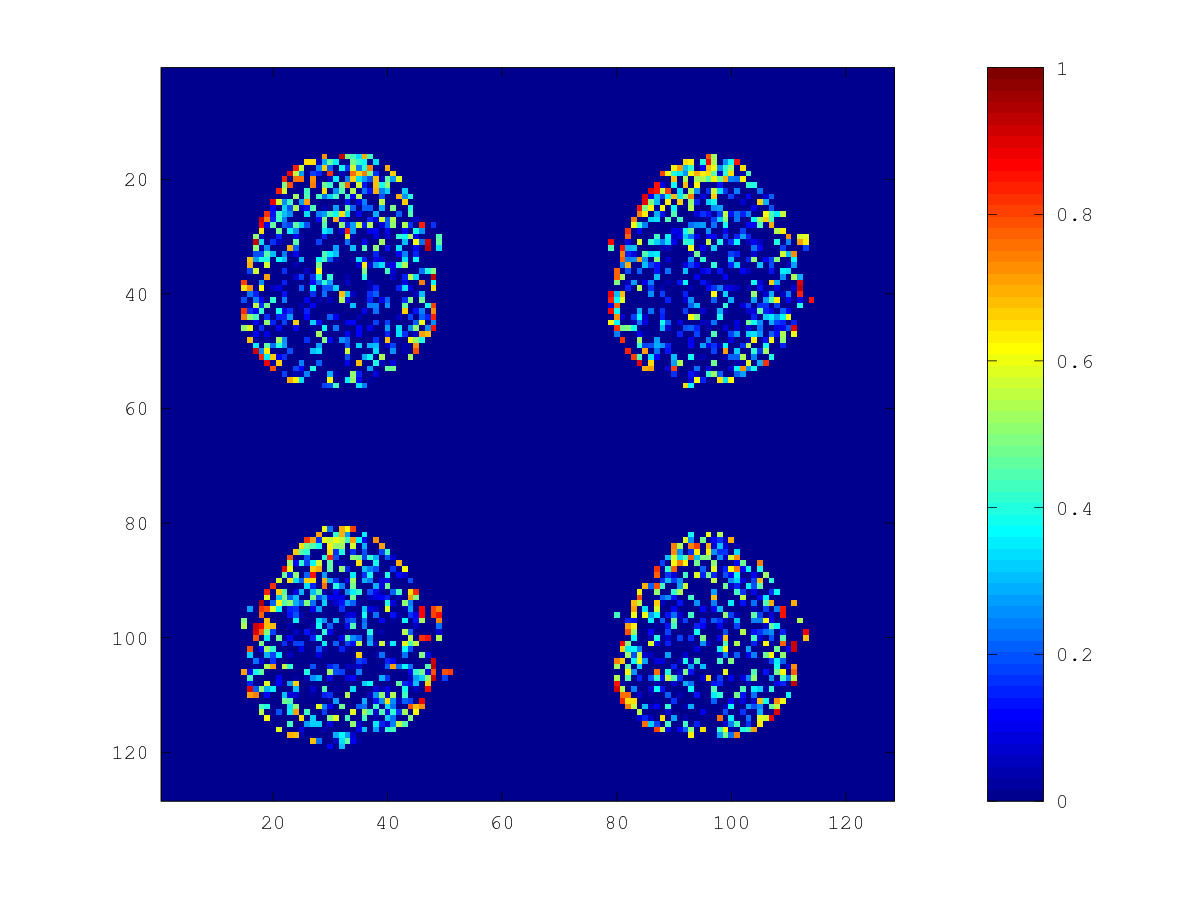

In [22]:
R2_map = niak_tseries2vol(R2,mask);
opt_v.vol_limits = [0 1];
opt_v.fwhm = 0;
niak_montage(R2_map(:,:,20:23),opt_v)
hdr.file_name = 'test.nii.gz';
niak_write_vol(hdr,R2_map)
mean(R2)

Very similar to the mass regression of motion parameters, with almost identical overall accuracy (8%). 

# Conclusions

Both mass univariate regression of motion parameters and ICA-based prediction are accurate at predicting fMRI fluctuations at the edges of the brain. Overall, on the low-motion subject presented here, both techniques explained about 8% of the variance. I did not include the results of the subject with mild and high motion. For the mild motion subject, explained variance (after cross-validation) was 11.9% for univariate regression, and 12% for ICA-based prediction. These numbers climbed to 27% and 13% for the high motion subject. Otherwise, all conclusions were qualitatively identical.  

We know that there are more motion-related fluctuations than that captured in fMRI time series with the model presented above, because the fMRI measures generated after correction still show an association with the amount of motion observed before correction. The prediction techniques used are very crude, and I am confident that a deep learning model should be able to achieve higher accuracy inside the brain. I have a feeling the architecture of the ICA prediction could be adapted in a deep learning model. Let's talk asap.   